In [10]:
import numpy as np
import matplotlib.pyplot as plt
import heapq
import itertools

In [11]:
f = [
    (0,'TTCTACGGGGGGAGACCTTTACGAATCACACCGGTCTTCTTTGTTCTAGCCGCTCTTTTTCATCAGTTGCAGCTAGTGCATAATTGCTCACAAACGTATC'), 
    (1,'TCTACGGGGGGCGTCATTACGGAATCCACACAGGTCGTTATGTTCATCTGTCTCTTTTCACAGTTGCGGCTTGTGCATAATGCTCACGAACGTATC'), 
    (2,'TCTACGGGGGGCGTCTATTACGTCGCCAACAGGTCGTATGTTCATTGTCATCATTTTCATAGTTGCGGCCTGTGCGTGCTTACGAACGTATTCC'), 
    (3,'TCCTAACGGGTAGTGTCATACGGAATCGACACGAGGTCGTATCTTCAATTGTCTCTTCACAGTTGCGGCTGTCCATAAACGCGTCCCGAACGTTATG'), 
    (4,'TATCAGTAGGGCATACTTGTACGACATTCCCCGGATAGCCACTTTTTTCCTACCCGTCTCTTTTTCTGACCCGTTCCAGCTGATAAGTCTGATGACTC'), 
    (5,'TAATCTATAGCATACTTTACGAACTACCCCGGTCCACGTTTTTCCTCGTCTTCTTTCGCTCGATAGCCATGGTAACTTCTACAAAGTTC'), 
    (6,'TATCATAGGGCATACTTTTACGAACTCCCCGGTGCACTTTTTTCCTACCGCTCTTTTTCGACTCGTTGCAGCCATGATAACTGCTACAAACTTC')
]

#### Question 1 : Longest common subsequence 

In [12]:
# utils #

def len_LCS (x, y, proportional= False):
    # returns only the len of the LCS
    return LCS(x, y, proportional)['len']
    
def values_LCS (x, y, proportional= False):
    #returns only the table
    return LCS(x, y, proportional)['LCS']

# dynprog LCS #
def LCS (x,y, proportional = False):
    # calculates the longest ongest common subsequence for the two given strings 
    m = len(x)
    n = len(y)
    
    # sets an empty table to memorize the length
    LSC = [[0] * (len(y)+1) for _ in range(len(x)+1)]

    #iterates on the two strings to find each position LCS 
    for i in range(1, len(x)+1):
        for j in range(1, len(y)+1):

            if x[i-1] == y[j-1] :
                LSC[i][j] = LSC[i-1][j-1]+ 1
            

            elif LSC[i-1][j] >= LSC[i][j-1]:
                LSC[i][j] = LSC[i-1][j]

            else:
                LSC[i][j] = LSC[i][j-1]

    if proportional:
        return {'LCS':np.array(LSC), 'len':(LSC[-1][-1])/float(m)}
    
    #return the table and the longest value
    return {'LCS':np.array(LSC), 'len':LSC[-1][-1]}


# dynprog Levinstein distance #
def levinstein_dist (st1, st2, proportional = False):
    
    mistakes = {}  # (indexes_st1,indexes_st2) : value
    penalties = {'ins':1 ,'del': 1, 'mut': 1}

    def levinstein_recursive (st1, start_st1, st2, start_st2, mistakes, penalties):
        
        ins_pen = penalties['ins']
        del_pen = penalties['del']
        mut_pen = penalties['mut']

        if len(st1) - start_st1 == 0 : 
            return len(st2) - start_st2

        if len(st2) - start_st2 == 0 :
            return len(st1) - start_st1

        if (start_st1, start_st2) in mistakes:
            return mistakes[(start_st1, start_st2)]

        if st1[start_st1] == st2[start_st2]:
            return levinstein_recursive(st1, start_st1+1, st2, start_st2+1, mistakes, penalties)

        else:
            value = 1 + min(
                ins_pen * levinstein_recursive(st1, start_st1+1, st2, start_st2, mistakes, penalties), # insertion
                del_pen * levinstein_recursive(st1, start_st1, st2, start_st2+1, mistakes, penalties), # deletion
                mut_pen * levinstein_recursive(st1, start_st1+1, st2, start_st2+1, mistakes, penalties)) # modification

        mistakes[(start_st1, start_st2)] =  value

        return value
    
    if proportional:
        return levinstein_recursive (st1, 0, st2, 0, mistakes, penalties) /float(len(st1))
     
    return levinstein_recursive (st1, 0, st2, 0, mistakes, penalties)


# Print LCS #       
def all_backtrack (lcs, x, y, i = None, j = None):
    # prints all unique LCS per a pair of strings
    
    if i == None : 
        i = len(x)

    if j == None:
        j = len(y)

    if i == 0 or j == 0:
        return set([""])

    if x[i-1] == y[j-1]:
        return set([string + str(x[i-1]) for string in all_backtrack(lcs, x, y, i-1, j-1)])

    else:
        set_of_lcs = set()

        if lcs[i][j-1] >= lcs[i-1][j]:
            set_of_lcs.update (all_backtrack(lcs, x, y, i, j-1))
        if lcs[i-1][j] >= lcs[i][j-1]:
            set_of_lcs.update (all_backtrack(lcs, x, y, i-1, j))


        return set_of_lcs
    
    
# Generate table #    
def permutation (array_of_strings, func, proportional = False, minproblem = False):
    # runs the given function func over all possible permutation in the given array
    
    N = len(array_of_strings)
    
    if minproblem:
        # minimize the diffrences 
        # the dif on the diagonal
        table_of_lcs = np.zeros((N,N))
    else:
        # max the similarirt 
        # the simi on the diagonal
        table_of_lcs = np.ones((N,N))
    
    for primary in array_of_strings:
        for secondary in array_of_strings:
            if (secondary[0] != primary[0]):
                
                                 
                table_of_lcs[primary[0]][secondary[0]] = func(primary[1],secondary[1], proportional)
                


    return table_of_lcs

 

#### Question 2 : Table of realtions between give strings

There are many methods to construct a weight matrix for this probelm. The naive one is to base the matrix on the LCS for each pair of strings. Yet, there are some modifiation that may increase the accuracy of the calculation. For example:
1. An integration of the length of the source string can indicate the porprotional similarity between two strings. I.e, a LCS in length ten implies lower similiarity if the source string was a thousand cahraters long rather then if it was of fifteen cahraters long. The naive method maintaint he property of nondrectional graph wherese the proportional one creates a directional graph. 

2. Using similarities indicates that the cost of all mistakes are equal; as the LCS algorithm does not account for whether a single char was deleted, inserted, or substituted. A weighted diffrences function can account for these parameters and perhaps generates a more accurate solution.

I explain further about the meaning of each option in Question 4. This short provide background for the reason I created four tables. 

In [13]:
# generate tables
similarity = permutation(f, len_LCS, proportional = False, minproblem = False)
dif = permutation(f, levinstein_dist, proportional = False, minproblem = True)

sim_per_len = permutation(f, len_LCS, proportional = True, minproblem = False)
dif_per_len = permutation(f, levinstein_dist, proportional = True, minproblem = True)

Naive (Absolute) comparison : non-directional


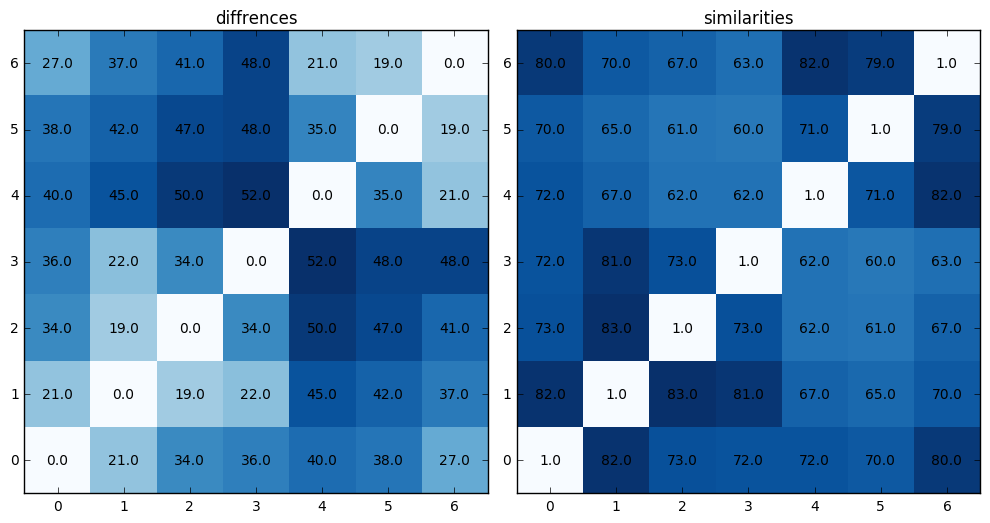

Porprotional to length of source gene: directional


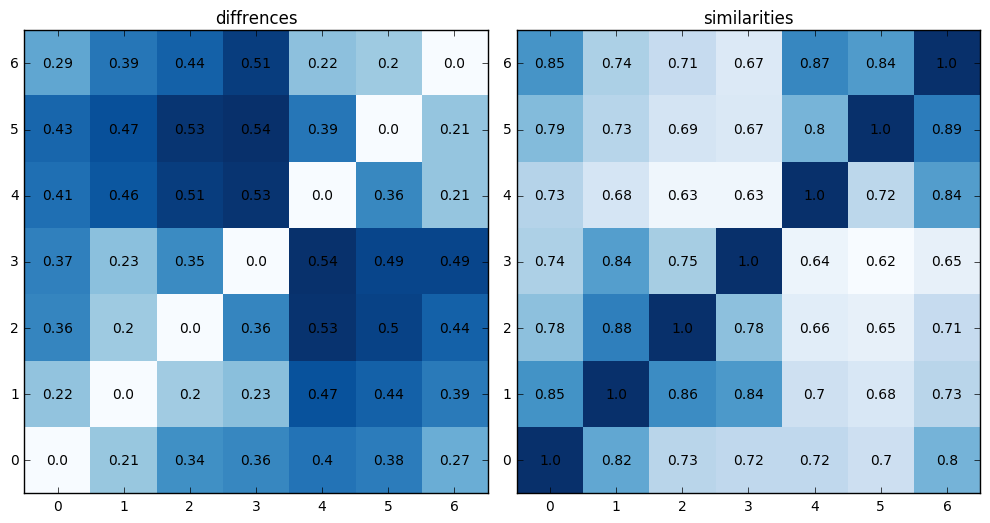

In [99]:
def plot_heatmap (to_print, name):    
    print name  
    
    fig, axes = plt.subplots(ncols=2, figsize=(10, 20))
    for ax, plot, name in zip(axes, to_print, ['diffrences', 'similarities']):
        heatmap = ax.imshow(plot, aspect='auto', cmap=plt.cm.Blues, interpolation = 'nearest', origin='lower')
        
        ax.set_title(name)
        for (j,i),label in np.ndenumerate(plot):
    
            ax.text(i,j, round(label,2) ,ha='center',va='center', color='black')
            ax.set(adjustable='box-forced', aspect='equal')
   
    fig.tight_layout()
    plt.show()

plot_heatmap([dif,similarity], 'Naive (Absolute) comparison : non-directional')
plot_heatmap([dif_per_len,sim_per_len], 'Porprotional to length of source gene: directional')


#### Question 3 : Manual examination of the table

I examined the Naive/similarity table, as produced by the LCS function for the given seven sequences. The Naive/similarity table is a maximization problem; the optimization is a result of maximizing similarity.

Assuming a complete tree, I can infer that there are six edges and based on the optimization task, I can conclude that these six edges are the six largest values of all possible edges.

I looked for the highest six LCSs and used them to build the tree.Knowing the shape of a tree, I can distinguish three different types of nodes: the root has only two edges (its two kids), all mid-nodes have three edges (a parent and two kids), and the leaf nodes have only one edge (parent).

The higest six edges for the Naive/similarity table are (each tupple contains the value and the two nodes) : 
```[(83.0, (2, 1)), (82.0, (1, 0)), (82.0, (6, 4)), (81.0, (3, 1)), (80.0, (6, 0)), (79.0, (6, 5))]```

The first task is to choose the root, as mentioned above, the node with two edges; in this case [0]. from there we can use the information in the array to build the tree. [0] kids are [1,6] and their kids, respectively, are ```[2,3]``` and ```[4,5]```.

The following function demonstrates this process

In [106]:
def manual_infer (matrix, minproblem = False):
    # An implementation of my manual method to find the family tree given a matrix of probabilities 
    # Assuming a number of nodes that fills a full tree 
    
    big_n = [] # big_n = [(0, (0, 0))] #value, index, index
    priority_coef = 1 if minproblem else -1
    in_tree = 7* [False] 
    
    for row in range(len(matrix)):
        for col in range(len(matrix)):
            if row < col:
                heapq.heappush(big_n, (priority_coef*matrix[row][col],(col, row)))

    # Choose the biggest probabilties (based on highest of the tree)
    tree_edges = []
    [tree_edges.append(heapq.heappop(big_n)) for _ in range(6)]
     
#     print tree_edges
    # Divided by levels -  root ; 2 connections // mid levels ; 3 connections // kids ;1 connection
    # count edges per node
    edges_per_node = {i:0 for i in range(7)}

    for edge in tree_edges:
        edges_per_node[edge[1][0]] += 1
        edges_per_node[edge[1][1]] += 1


    # based on the inforamtion gained - infer the tree
    build_tree = []
    root = edges_per_node.keys()[edges_per_node.values().index(2)] # root has two kids (and the only node with 2 edges)
    in_tree[root] = True
    build_tree.append(root)

    nodes_to_check = [root]
    while False in in_tree :

        current = nodes_to_check.pop()
        kids = []

        for edge in tree_edges:

            if edge[1][0] == current or edge[1][1] == current:

                kid = filter(lambda x: x != current, edge[1])[0] 

                if in_tree[kid]:
                    continue  

                kids.append(kid)
                in_tree[kid] = True

        if len(kids) == 0:
            continue
        else:

            build_tree.append([current, kids])
            nodes_to_check.append(kids[0]) 
            nodes_to_check.append(kids[1])  

    return build_tree         


print 'Manual examination result:'
print 'Naive/ similarity : {}'.format( manual_infer(similarity, False))
# print 'Naive/ diffrences : {}'.format( manual_infer(dif, True))
# print
# print 'Proportional / similarity : {}'.format( manual_infer(sim_per_len, False))
# print 'Proportional / diffrences : {}'.format( manual_infer(dif_per_len, True))

Manual examination result for all discussed matrices
Naive/ similarity : [0, [0, [1, 6]], [6, [4, 5]], [1, [2, 3]]]


#### Question 4 : Probabilities of mutation, insertions and deletions

The probability of preforming a mistake (of any kind) on a single character in a gene evolution process is $P_{single-mistake}$; the probability to preform k mistakes while tansforming from a n long source string can be denotated by the binomial distribution as: $P_{string-disparity} = \binom{n}{k} P_{single-mistake}^ k(1-P_{single-mistake})^{n-k} $

With bigger dataset the one presented in this assignment, we can empirically estimate these probabilities. 

Using similar process, we can infer the probability of each type of mistake (insertion, deletion, or modification). Using conditional probability, we can divide the number of each type of mistake happens by the number of total mistakes to estimate the probability of an observed mistake to be a specific one thus the probability of any given type of mistake. Demonstrated by insertion.
$$  P(insertion | mistake ) = \frac{number-of-false-insertion}{total-mistakes}$$

$$P_{insertion} =  P(insertion | mistake ) * P_{mistake} $$

* Practically, to find the number each mistake happen we would need to use a transparent dataset; one that either has the transformation information available or one that all of its mutations are explanatory via only one possible type of mistake (i.e a longer mutation must have had insertion at some point)

These probabilities can be used to create a weighted differences matrix. Using the probability vector to change the selection in the Levenshtein's distance algorithm. As an example, assuming a string 'aab' is transforming to 'aac', the most likely change that happened (in a un weighted function) will be a modification. If the modification is of low probability, comparing to the other two mistakes; maybe the most likely mistake is an insertion of c and a deletion of b. To account for these probabilities in a minimization algorithm, the probability vector holds normalized $1-p$ to account for the penalization a low probability event should have. This weighting system is implemented in the Levinstein's distance function (yet, not used).

#### Question 5 : Tree building algorithm

The complexity of creating the similarity matrix is based on LCS or Levinstein's difrences in a complexity O(M^2) for each pair, for N^2 potential psirs. Hence,the overall complexity of generating the matrix is O(M^2N^2).

I started by writing a brute force solution to test the manual method I used. The brute force resulted in the same tree using the Naive/ similarity matrix. Confirms a previous concern that there will be a disparity between different methods. The Brute Force algorithm runs in a factorial complexity $O(N+1!)$ accounting for all possible trees and the calculation of each tree in each possibility. The high complexity makes this algorithm unfavorable generally, yet possible to use in the given small dataset; the high accuracy is its advantage. 

To optimize for complexity, I wrote a greedy algorithm. The greedy algorithm is based on two choices. Its complexity is polynomial O(N^2). The first is choosing the root and later, the greedy choice is finding the optimal pair of nodes represent the kids. The algorithm is choosing the root as the node that has the highest similarity to all other nodes. Assuming that an investor will be more likely to similar to its entire tree rather than any other relation on the family tree. I.e., root relations to the leaves is higher than the relation amongst themselves. As I do not have an algebraic proof for the greedy choice, I consider that with a bigger dataset, I can provide a probabilistic accuracy. For the given dataset, the result was equal to the ones given by the brute force in two cases: Naive/ similarity and Proportional / differences. 

A dynamic programming solution presents an absolute accuracy in a polynomial complexity O(N^2). Introduces higher space complexity. I did not manage to code a dynamic programing solution, yet this is my estimation based on my knowledge.

In [116]:
## BF ##
def BF (matrix, minimazation, porprotional):
    # BF solution for seven strings 
    
    M = len(matrix)
    
    #all permutations
    premutation = list(itertools.permutations([i for i in range(7)]))
    probability_list = [] # index, probability

    # find the probability for all trees
    for index, per in enumerate(premutation):
        
        
        if porprotional:
            # probabilties are mutliplied to create the additional probability
            prob = matrix[per[0]][per[1]]*matrix[per[0]][per[2]]*matrix[per[1]][per[3]]*matrix[per[1]][per[4]]*matrix[per[2]][per[5]]*matrix[per[2]][per[6]]
        
        elif not porprotional:
            #amounts are added to a summation of the similarty/diffrences
            prob = matrix[per[0]][per[1]]+matrix[per[0]][per[2]]+matrix[per[1]][per[3]]+matrix[per[1]][per[4]]+matrix[per[2]][per[5]]+matrix[per[2]][per[6]]

            
        probability_list.append((index, prob))
      
    #choose the optimized solution
    if minimazation:
        results = min(probability_list, key =lambda x: x[1]) 
    else:
        results = max(probability_list, key =lambda x: x[1])
        
    return { 'probability': results[1], 'seq': premutation[results[0]]}


print 'Naive/ similarity : {}'.format( BF(similarity, False, False))
print 'Naive/ diffrences : {}'.format( BF(dif, False, True))
print
print 'Proportional / similarity : {}'.format( BF(sim_per_len, True, False))
print 'Proportional / diffrences : {}'.format( BF(dif_per_len, True, True))


Naive/ similarity : {'seq': (0, 1, 6, 2, 3, 4, 5), 'probability': 487.0}
Naive/ diffrences : {'seq': (0, 3, 4, 5, 6, 1, 2), 'probability': 7464960000.0}

Proportional / similarity : {'seq': (0, 3, 4, 5, 6, 1, 2), 'probability': 4.0243677677256464}
Proportional / diffrences : {'seq': (0, 1, 6, 2, 3, 4, 5), 'probability': 0.00011612722898511766}


In [95]:
## Greedy ##
# Decision 1: root is the node with the optimized multiplied probability to all other nodes
# from there on, the greedy choice is the one that chooses the highest pair of nodes to be the kids

def greedy (similarity_matrix, porprotional = True, minimazation = True): 
    in_tree = [False]*7
    
    
    ##### make sure the take care of the 0!!!
    if minimazation:
        root = min([(np.prod(x), index) for index, x in enumerate(similarity_matrix)]) # min ∑ P(i|root) , least amount of changes
    elif not minimazation:
        root = max([(np.prod(x), index) for index, x in enumerate(similarity_matrix)]) # max ∑ P(i|root) , highest similarity

        
        
    in_tree[root[1]]= True

    nodes = [root[1]] # queue of all iterative nodes
    tree = [root[1]] # building the tree
    probability = 1 # optimized probability

    while nodes and False in in_tree :
        current = nodes.pop(0)
        if minimazation :
            kids = [kid[1] for kid in sorted([(similarity_matrix[current][i], i) for i in range(7) if not in_tree[i]])[:2]]
        elif not minimazation:
            kids = [kid[1] for kid in sorted([(similarity_matrix[current][i], i) for i in range(7) if not in_tree[i]], reverse=True)[:2]]

        in_tree[kids[0]] = True
        in_tree[kids[1]] = True
        
        if porprotional:
            probability *= similarity_matrix[current][kids[0]]
            probability *= similarity_matrix[current][kids[1]]
            
        elif not porprotional:
            probability += similarity_matrix[current][kids[0]]
            probability += similarity_matrix[current][kids[1]]

        tree.append((current, kids))
        nodes.append(kids[1])
        nodes.append(kids[0])


    return tree, probability



print 'Naive/ similarity : {}'.format( greedy(similarity, False, False))
print 'Naive/ diffrences : {}'.format( greedy(dif, False, True))
print
print 'Proportional / similarity : {}'.format( greedy(sim_per_len, True, False))
print 'Proportional / diffrences : {}'.format( greedy(dif_per_len, True, True))


Naive/ similarity : ([0, (0, [1, 6]), (6, [4, 5]), (1, [2, 3])], 488.0)
Naive/ diffrences : ([0, (0, [1, 6]), (6, [5, 4]), (1, [2, 3])], 130.0)

Proportional / similarity : ([6, (6, [4, 0]), (0, [1, 2]), (4, [5, 3])], 0.20369610821204159)
Proportional / diffrences : ([0, (0, [1, 6]), (6, [5, 4]), (1, [2, 3])], 0.00011612722898511769)


In [139]:
print max(enumerate([1,2,3,4,5,3,5,2]), key = index)

TypeError: 'int' object is not callable

In [ ]:

    def count_mistakes (similarity_matrix, child1, child2, best_tree, ):
        

        if (child1, child2) in best_tree:
            return mistakes[(start_st1, start_st2)]

        if st1[start_st1] == st2[start_st2]:
            return count_mistakes(st1, start_st1+1, st2, start_st2+1, mistakes)

        else:
            value = 1 + min(count_mistakes(st1, start_st1+1, st2, start_st2, mistakes), # insertion
                count_mistakes(st1, start_st1, st2, start_st2+1, mistakes), # deletion
                count_mistakes(st1, start_st1+1, st2, start_st2+1, mistakes)) # modification

        mistakes[(start_st1, start_st2)] =  value

        return value

    return count_mistakes (st1, 0, st2, 0, mistakes)

